# Tutorial 4
## MA course in Artificial Intelligence 2022/2023

In [ ]:
!rm -rf AI2020MA
!git clone https://github.com/UmbertoJr/AI2022MA.git

In [97]:
# Imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IO_manager.io_tsp import TSP_Instance_Creator
from solvers.TSP_solver import Solver_TSP
from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from solvers.constructive_algorithms import compute_length
from solvers.local_search import TwoOpt

# If you are not running from your local, add the prefix AI2021MA (comment the previous 3 lines and use instead the following 3 lines)
# from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# from AI2022MA.solvers.local_search import TwoOpt
# from AI2022MA.solvers.TSP_solver import Solver_TSP
# from AI2022MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from AI2022MA.solvers.constructive_algorithms import compute_length

# Iterated Local Search for the Travelling Salesman Problem

Let's read the standard TSP instance called 'd198.tsp'

name: d198
nPoints: 198
best_sol: 15780.0


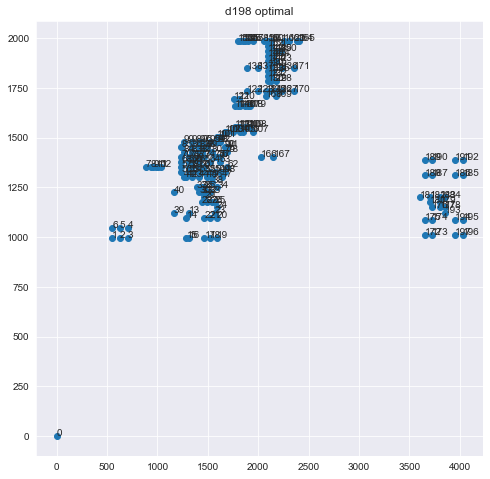

In [98]:
# Creating a TSP instance and printing the information about the instance and plotting the data.
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [99]:
# A class that contains the methods to perform the double bridge perturbation and to compute
# the difference in cost between the edges that will be removed by the double bridge perturbation
# and the edges that will be added by the double bridge perturbation.
class DoubleBridge:

  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    """
    It computes the difference between the cost of the edges that will be added by the double bridge perturbation and
    the cost of the edges that will be removed by the double bridge perturbation.
    :param solution: The solution to be perturbed.
    :param a:        The first index of the first bridge.
    :param b:        The first city of the first bridge.
    :param c:        The index of the first city in the first bridge.
    :param d:        The number of cities in the TSP instance.
    :param matrix:   The distance matrix of the problem.
    :return:         The difference between the cost of the edges that will be added by the double bridge perturbation and
                     the cost of the edges that will be removed by the double bridge perturbation.
    """

    # Computing the cost of the edges that will be removed by the double bridge perturbation
    to_remove = matrix[solution[a - 1], solution[a]] + \
                matrix[solution[b - 1], solution[b]] + \
                matrix[solution[c - 1], solution[c]] + \
                matrix[solution[d - 1], solution[d]]

    # Computing the cost of the edges that will be added by the double bridge perturbation
    to_add = matrix[solution[a], solution[c - 1]] + \
             matrix[solution[b], solution[d - 1]] + \
             matrix[solution[c], solution[a - 1]] + \
             matrix[solution[d], solution[b - 1]]

    # Computing the difference between the cost of the edges that will be added and removed by the double bridge perturbation
    gain = to_add - to_remove

    return gain

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    """
    Given a solution, the cost of that solution, and the cost matrix, return a new solution that is a random perturbation of the original solution,
    by randomly selecting 4 points in the solution, and then swaps the order of the points between the 4 points.
    :param solution:    The current solution, that is a list of the indices of the cities in the order they are visited.
    :param actual_cost: The cost of the current solution.
    :param matrix:      The matrix of distances between cities.
    :return:            The new solution and the new cost.
    """
    # Randomly selecting 4 points in the solution, and then swapping the order of the points between the 4 points
    a, b, c, d = np.sort(np.random.choice(matrix.shape[0], size=4, replace=False))

    # Defining the segments of the solution ABCD
    B = solution[a:b]
    C = solution[b:c]
    D = solution[c:d]
    A = np.concatenate((solution[d:], solution[:a]))

    # Calculating the difference in cost between the current solution and the new solution
    gain = DoubleBridge.difference_cost(solution, a, b, c, d, matrix)

    # Defining the segments of the new solution ADCB
    new_solution = np.concatenate((A, D, C, B))

    # Adding the actual cost and the gain to get the new cost
    new_cost = actual_cost + gain

    return new_solution, new_cost

In [100]:
# Example of perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 5.416687019038687
[11  0  1  2 10  5  6  7  8  9  3  4] 4.98982617924152


Given ABCD = [  0  1  2  3  4  5  6  7  8  9 10 11]
and   ADCB = [ 11  0  1  2 10  5  6  7  8  9  3  4]

Which are the vertices in the segments A, B, C and D here?
Which are the vertices a, b, c and d?

A is from 11 to 2
B is from 3 to 4
C is 5 to 9
D is 10

a is 3
b is 5
c is 10
d is 11

## Iterated Local Search


Here you need to implement the three variants of the ILS we saw in class

To boost the time performances please use the cython class **two_opt_with_candidate**.


In [101]:
def my_local_search(s, c, d_matrix):
  """
  Given a solution, cost of the solution, and the distance matrix, return a new solution with a lower cost.
  :param s:        The solution to be improved (a list of integers, where each integer represents a city).
  :param c:        The cost of the solution.
  :param d_matrix: A matrix of distances between cities.
  :return:         The new solution and the new cost.
  """
  new_solution, new_cost = s, c

  for data in TwoOpt.local_search(s, c, d_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data

  return new_solution, new_cost


# This class implements the Iterated Local Search (ILS) algorithm for the Better problem
class ILSBetter:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix, return the new solution and the new actual cost.
    :param s0:       The solution to be improved (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or A 2D array of the cost of each edge in the graph.
    """
    global cost_sol_better
    # Calling the local search function and passing the solution, actual cost and matrix as parameters
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    calls = 1

    cost_sol_better.append(s_star_cost)

    while True:
      # implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # implement acceptance criterion
      if s_star_prime_cost < s_star_cost:
        s_star, s_star_cost = s_star_prime, s_star_prime_cost
        cost_sol_better.append(s_star_cost)

      yield s_star, s_star_cost, calls, False


# This class implements the Iterated Local Search (ILS) algorithm for the Random Walk (RW) problem
class ILSRw:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix, return the new solution and the new actual cost.
    :param s0:       The solution to be improved (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or A 2D array of the cost of each edge in the graph.
    """
    global cost_sol_RW

    # Using the local search algorithm to find a better solution
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    calls = 1

    cost_sol_RW.append(s_star_cost)

    while True:
      # Implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # Implement acceptance criterion
      s_star, s_star_cost = s_star_prime, s_star_prime_cost
      cost_sol_RW.append(s_star_cost)

      yield s_star, s_star_cost, calls, False


# This class implements the Iterated Local Search (ILS) algorithm for the
# Large Step Markov Chain (LSMC) problem
class ILSLsmc:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix,
    return the new solution and the new actual cost.
    It's a simulated annealing algorithm that uses a local search as a perturbation function.
    :param s0:       The solution to be perturbed (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or a 2D array of the cost of each edge in the graph.
    """
    global cost_sol_better

    # Using the local search algorithm to find a better solution.
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    calls = 1

    cost_sol_LSMC.append(s_star_cost)

    # Setting initial temperature such that acceptance probability is close to 1.
    temperature = np.abs(s_star_cost - s0_cost) * 100
    decrease = 0.95

    while True:
      # implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # implement acceptance criterion
      if ILSLsmc.acceptance_criterion(s_star_cost, s_star_prime_cost, temperature):
        s_star, s_star_cost = s_star_prime, s_star_prime_cost
        cost_sol_LSMC.append(s_star_cost)

      temperature *= decrease
      yield s_star, s_star_cost, calls, False

  @staticmethod
  def acceptance_criterion(s_star_cost, s_star_prime_cost, temperature):
    """
    If the new cost is better than the best cost, accept it, otherwise accept it
    with a probability that is proportional to the difference between the new cost and the best cost (the probability decreases as the temperature decreases).
    :param s_star_cost:       The cost of the best solution found so far.
    :param s_star_prime_cost: The cost of the new solution.
    :param temperature:       The current temperature of the system, a parameter that controls the probability of accepting a worse solution.
    :return:                  A boolean value.
    """

    if s_star_prime_cost < s_star_cost:
      return True
    else:
      alpha = np.random.rand(1)
      prob = np.exp((s_star_cost - s_star_prime_cost) / temperature)

      if alpha <= prob:
        return True
      else:
        return False

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task! 

In [102]:
seeds = [0, 123, 333]
time_to_solve = 180  # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

# Creating a dictionary with the names of the instances as keys and an empty dictionary as values.
names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]
samples = {name: {} for name in names_instances}
collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]

# Creating a list of initializers and a list of functions that will be used to initialize the weights.
initializers = ["random"]
init_functions = [Random_Initializer.random_method]

# Creating a list of strings and a list of functions.
improvements = ["ILS-Better", "ILS-RW", "ILS-LSMC"]
improve_functions = [ILSBetter.solve, ILSRw.solve, ILSLsmc.solve]

results = []
index = []

# Running the solver for each instance, for each improvement method, for each initializer, for each seed.
for s_ in seeds:
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve] = np.round(np.abs(np.array(collectors[j]) - ic.best_sol) / ic.best_sol * 100, 2)

index = pd.MultiIndex.from_tuples(index, names=['problem', 'optimal length', 'method', 'seed'])

df = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"])
df
# df.to_csv(str(time_to_solve) + '_seconds_' + str(seeds[-1]) + '_data.csv', index=True)

,,,,tour length,gap,time to solve,calls local search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-Better",0,15852.0,0.46,180.077,735
pr439.tsp,107217.0,"initialized with random, improved with ILS-Better",0,111003.0,3.53,180.338,129
u1060.tsp,224094.0,"initialized with random, improved with ILS-Better",0,241031.0,7.56,182.027,19
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,16489.0,4.49,180.021,703
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,121800.0,13.60,180.539,132
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,243771.0,8.78,189.922,19
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,15836.0,0.35,180.119,704
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,120331.0,12.23,180.284,122
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,249487.0,11.33,180.440,19


In [103]:
def statistic_creator(dataframe):
  pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', None)
  pd.set_option('display.max_colwidth', None)

  df = dataframe

  #Statistics for local search calls
  result = []
  index = []

  lowest_df = pd.DataFrame()
  for method in improvements:
    for problem in names_instances:
      ILS_df = df.filter(like = method, axis=0)
      ILS_Res_df = ILS_df.filter(like = problem, axis=0)
      ILS_LSC_mean_df = round(ILS_Res_df["calls local search"].mean(),2)
      ILS_LSC_std_df = round(ILS_Res_df["calls local search"].std(),2)
      ILS_gap_mean_df = round(ILS_Res_df["gap"].mean(),3)
      ILS_gap_std_df = round(ILS_Res_df["gap"].std(),3)
      if method == 'ILS-Better':
        ILS_problem_df = df.filter(like = problem, axis=0)
        lowest_df = pd.concat([lowest_df, ILS_problem_df[ILS_problem_df.gap == ILS_problem_df.gap.min()]])
      result.append([problem, ILS_gap_mean_df, ILS_LSC_mean_df, ILS_gap_std_df, ILS_LSC_std_df])
      index.append(method)

  res_df = pd.DataFrame(result, index=index, columns=["Problem", "Mean Gap", "Mean Calls", "STD Gap", "STD Calls"])
  display(res_df)

  lowest_df.rename(columns={'method': 'initialized with random, method'}, inplace=True)
  display(lowest_df)

statistic_creator(dataframe = df)

,Problem,Mean Gap,Mean Calls,STD Gap,STD Calls
ILS-Better,d198.tsp,0.767,733.00,0.472,6.24
ILS-Better,pr439.tsp,3.220,129.00,0.300,4.00
ILS-Better,u1060.tsp,9.283,18.67,1.788,0.58
ILS-RW,d198.tsp,5.243,708.33,0.957,5.03
ILS-RW,pr439.tsp,11.210,127.00,3.773,4.36
ILS-RW,u1060.tsp,9.437,18.33,0.650,2.08
ILS-LSMC,d198.tsp,0.400,715.67,0.070,15.31
ILS-LSMC,pr439.tsp,9.780,125.67,2.126,3.21
ILS-LSMC,u1060.tsp,10.973,18.67,0.761,0.58


,,,,tour length,gap,time to solve,calls local search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,15836.0,0.35,180.119,704
pr439.tsp,107217.0,"initialized with random, improved with ILS-Better",333,110363.0,2.93,180.436,125
u1060.tsp,224094.0,"initialized with random, improved with ILS-Better",0,241031.0,7.56,182.027,19


#### Problem: d198.tsp

In [117]:
df1 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'd198.tsp', axis=0)
df1

tour length  \
problem  optimal length method                                            seed                
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0         15852.0   
                        initialized with random, improved with ILS-RW     0         16489.0   
                        initialized with random, improved with ILS-LSMC   0         15836.0   
                        initialized with random, improved with ILS-Better 123       15864.0   
                        initialized with random, improved with ILS-RW     123       16556.0   
                        initialized with random, improved with ILS-LSMC   123       15856.0   
                        initialized with random, improved with ILS-Better 333       15987.0   
                        initialized with random, improved with ILS-RW     333       16777.0   
                        initialized with random, improved with ILS-LSMC   333       15839.0   

                                                                                 gap  \
problem  optimal length method                                            seed         
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0     0.46   
                        initialized with random, improved with ILS-RW     0     4.49   
                        initialized with random, improved with ILS-LSMC   0     0.35   
                        initialized with random, improved with ILS-Better 123   0.53   
                        initialized with random, improved with ILS-RW     123   4.92   
                        initialized with random, improved with ILS-LSMC   123   0.48   
                        initialized with random, improved with ILS-Better 333   1.31   
                        initialized with random, improved with ILS-RW     333   6.32   
                        initialized with random, improved with ILS-LSMC   333   0.37   

                                                                                time to solve  \
problem  optimal length method                                            seed                  
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0           180.077   
                        initialized with random, improved with ILS-RW     0           180.021   
                        initialized with random, improved with ILS-LSMC   0           180.119   
                        initialized with random, improved with ILS-Better 123         180.159   
                        initialized with random, improved with ILS-RW     123         180.171   
                        initialized with random, improved with ILS-LSMC   123         180.132   
                        initialized with random, improved with ILS-Better 333         180.070   
                        initialized with random, improved with ILS-RW     333         180.216   
                        initialized with random, improved with ILS-LSMC   333         180.151   

                                                                                calls local search  
problem  optimal length method                                            seed                      
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0                    735  
                        initialized with random, improved with ILS-RW     0                    703  
                        initialized with random, improved with ILS-LSMC   0                    704  
                        initialized with random, improved with ILS-Better 123                  738  
                        initialized with random, improved with ILS-RW     123                  713  
                        initialized with random, improved with ILS-LSMC   123                  710  
                        initialized with random, improved with ILS-Better 333                  726  
                        initialized with random, improved with ILS-RW     333           

In [118]:
df1.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",15852.0,15901.000000,74.719475
"initialized with random, improved with ILS-LSMC",15836.0,15843.666667,10.785793
"initialized with random, improved with ILS-RW",16489.0,16607.333333,150.706116


In [105]:
df1.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",0.46,0.766667,0.471840
"initialized with random, improved with ILS-LSMC",0.35,0.400000,0.070000
"initialized with random, improved with ILS-RW",4.49,5.243333,0.956887


In [106]:
df1.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",726,733.000000,6.244998
"initialized with random, improved with ILS-LSMC",704,715.666667,15.307950
"initialized with random, improved with ILS-RW",703,708.333333,5.033223


The best result is found when initialized with random, and improved using **ILS-LSMC** as an acceptance criterion with respect to the *tour length* (Best: 15836; Avg: 15843; Std: 10.79), the *gap* (Best: 0.35; Avg: 0.40; Std: 0.07), while for *number of calls* the best result is with **ILS-RW** (Best: 703; Avg: 708.33; Std: 5.03).

#### Problem: pr439.tsp

In [119]:
df2 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'pr439.tsp', axis=0)
df2

tour length  \
problem   optimal length method                                            seed                
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0        111003.0   
                         initialized with random, improved with ILS-RW     0        121800.0   
                         initialized with random, improved with ILS-LSMC   0        120331.0   
                         initialized with random, improved with ILS-Better 123      110651.0   
                         initialized with random, improved with ILS-RW     123      114569.0   
                         initialized with random, improved with ILS-LSMC   123      116240.0   
                         initialized with random, improved with ILS-Better 333      110363.0   
                         initialized with random, improved with ILS-RW     333      121342.0   
                         initialized with random, improved with ILS-LSMC   333      116531.0   

                                                                                   gap  \
problem   optimal length method                                            seed          
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0      3.53   
                         initialized with random, improved with ILS-RW     0     13.60   
                         initialized with random, improved with ILS-LSMC   0     12.23   
                         initialized with random, improved with ILS-Better 123    3.20   
                         initialized with random, improved with ILS-RW     123    6.86   
                         initialized with random, improved with ILS-LSMC   123    8.42   
                         initialized with random, improved with ILS-Better 333    2.93   
                         initialized with random, improved with ILS-RW     333   13.17   
                         initialized with random, improved with ILS-LSMC   333    8.69   

                                                                                 time to solve  \
problem   optimal length method                                            seed                  
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0           180.338   
                         initialized with random, improved with ILS-RW     0           180.539   
                         initialized with random, improved with ILS-LSMC   0           180.284   
                         initialized with random, improved with ILS-Better 123         180.876   
                         initialized with random, improved with ILS-RW     123         181.099   
                         initialized with random, improved with ILS-LSMC   123         180.272   
                         initialized with random, improved with ILS-Better 333         180.436   
                         initialized with random, improved with ILS-RW     333         180.970   
                         initialized with random, improved with ILS-LSMC   333         181.091   

                                                                                 calls local search  
problem   optimal length method                                            seed                      
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0                    129  
                         initialized with random, improved with ILS-RW     0                    132  
                         initialized with random, improved with ILS-LSMC   0                    122  
                         initialized with random, improved with ILS-Better 123                  133  
                         initialized with random, improved with ILS-RW     123                  124  
                         initialized with random, improved with ILS-LSMC   123                  128  
                         initialized with random, improved with ILS-Better 333                  125  
                         initialized

In [120]:
df2.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",110363.0,110672.333333,320.532890
"initialized with random, improved with ILS-LSMC",116240.0,117700.666667,2282.577563
"initialized with random, improved with ILS-RW",114569.0,119237.000000,4049.087428


In [108]:
df2.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",2.93,3.22,0.300500
"initialized with random, improved with ILS-LSMC",8.42,9.78,2.126053
"initialized with random, improved with ILS-RW",6.86,11.21,3.773341


In [109]:
df2.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",125,129.000000,4.000000
"initialized with random, improved with ILS-LSMC",122,125.666667,3.214550
"initialized with random, improved with ILS-RW",124,127.000000,4.358899


The best result is found when initialized with random, and improved using **ILS-Better** as an acceptance criterion with respect to the *tour length* (Best: 110363; Avg: 110672.33; Std: 320.53), the *gap* (Best: 2.93; Avg: 3.22; Std: 0.30), while for *number of calls* the best result is with **ILS-LSMC** (Best: 122; Avg: 125.67; Std: 3.21).

#### Problem: u1060.tsp

In [121]:
df3 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'u1060.tsp', axis=0)
df3

tour length  \
problem   optimal length method                                            seed                
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0        241031.0   
                         initialized with random, improved with ILS-RW     0        243771.0   
                         initialized with random, improved with ILS-LSMC   0        249487.0   
                         initialized with random, improved with ILS-Better 123      244615.0   
                         initialized with random, improved with ILS-RW     123      246672.0   
                         initialized with random, improved with ILS-LSMC   123      249834.0   
                         initialized with random, improved with ILS-Better 333      249046.0   
                         initialized with random, improved with ILS-RW     333      245274.0   
                         initialized with random, improved with ILS-LSMC   333      246718.0   

                                                                                   gap  \
problem   optimal length method                                            seed          
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0      7.56   
                         initialized with random, improved with ILS-RW     0      8.78   
                         initialized with random, improved with ILS-LSMC   0     11.33   
                         initialized with random, improved with ILS-Better 123    9.16   
                         initialized with random, improved with ILS-RW     123   10.08   
                         initialized with random, improved with ILS-LSMC   123   11.49   
                         initialized with random, improved with ILS-Better 333   11.13   
                         initialized with random, improved with ILS-RW     333    9.45   
                         initialized with random, improved with ILS-LSMC   333   10.10   

                                                                                 time to solve  \
problem   optimal length method                                            seed                  
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0           182.027   
                         initialized with random, improved with ILS-RW     0           189.922   
                         initialized with random, improved with ILS-LSMC   0           180.440   
                         initialized with random, improved with ILS-Better 123         182.096   
                         initialized with random, improved with ILS-RW     123         181.507   
                         initialized with random, improved with ILS-LSMC   123         180.530   
                         initialized with random, improved with ILS-Better 333         189.138   
                         initialized with random, improved with ILS-RW     333         190.083   
                         initialized with random, improved with ILS-LSMC   333         188.781   

                                                                                 calls local search  
problem   optimal length method                                            seed                      
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0                     19  
                         initialized with random, improved with ILS-RW     0                     19  
                         initialized with random, improved with ILS-LSMC   0                     19  
                         initialized with random, improved with ILS-Better 123                   18  
                         initialized with random, improved with ILS-RW     123                   16  
                         initialized with random, improved with ILS-LSMC   123                   18  
                         initialized with random, improved with ILS-Better 333                   19  
                         initialized

In [122]:
df3.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",241031.0,244897.333333,4014.952096
"initialized with random, improved with ILS-LSMC",246718.0,248679.666667,1707.689765
"initialized with random, improved with ILS-RW",243771.0,245239.000000,1450.816667


In [111]:
df3.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",7.56,9.283333,1.788193
"initialized with random, improved with ILS-LSMC",10.10,10.973333,0.760548
"initialized with random, improved with ILS-RW",8.78,9.436667,0.650103


In [112]:
df3.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",18,18.666667,0.577350
"initialized with random, improved with ILS-LSMC",18,18.666667,0.577350
"initialized with random, improved with ILS-RW",16,18.333333,2.081666


The best result is found when initialized with random, and improved using **ILS-Better** as an acceptance criterion with respect to the *tour length* (Best: 241031; Avg: 244897.33) but standard deviation is very high (Std: 4014.95). If a lower std is preferred, then it is better to use **ILS-RW** for the tour length, with similar min and avg values and lower std.
Concerning the *gap*, **ILS-Better** has good values for min and avg, but bad for std (Best: 7.56; Avg: 9.28; Std: 1.79), so **ILS-RW** if preferable (Best: 9.78; Avg: 9.44; Std: 0.65).
Finally, for the *number of calls*, **ILS-LSMC** and **ILS-Better** have exactly same values, **ILS-RW** has 2 calls less but a higher std.

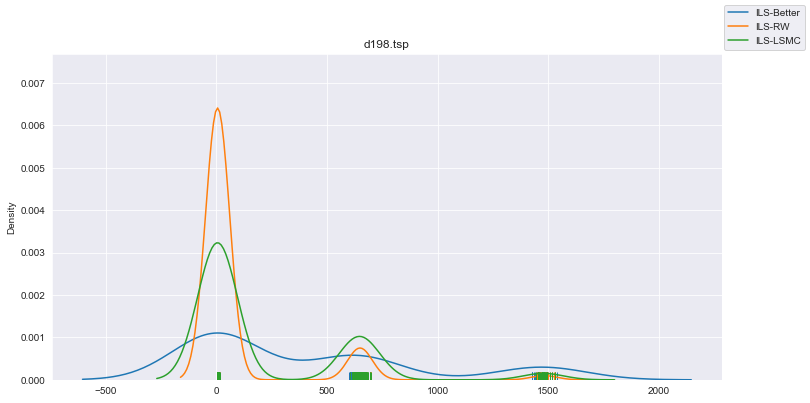

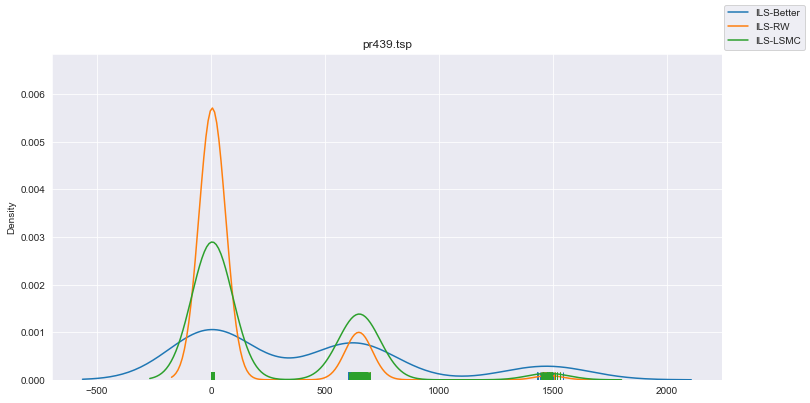

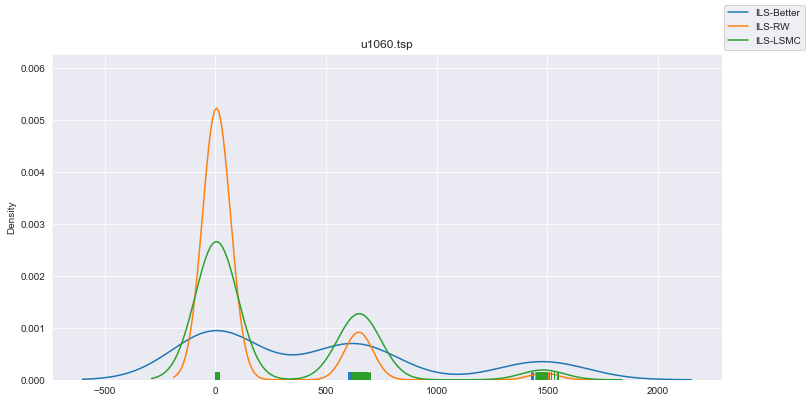

In [113]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(12, 6))
    for improve in improvements:
      sns.distplot(samples[instance][improve], rug=True, hist=False, label=improve)

    fig.legend()
    plt.title(instance)
    plt.show()

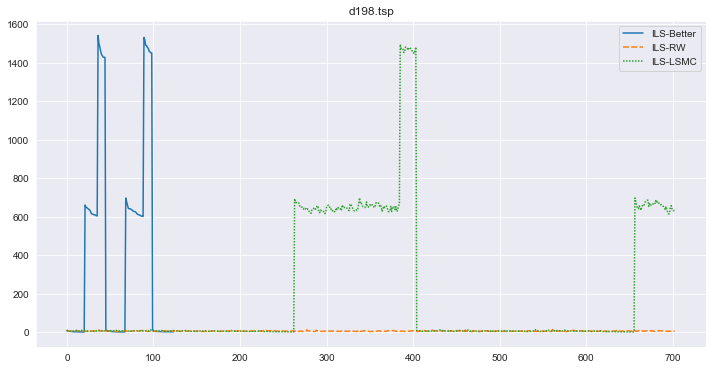

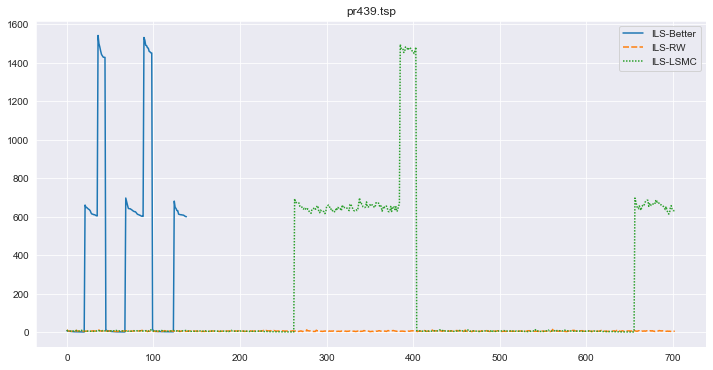

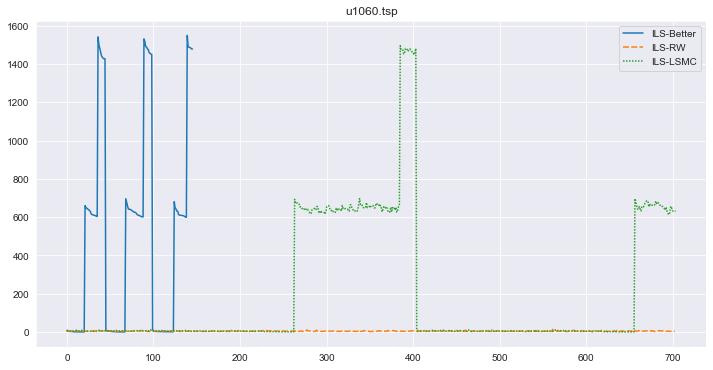

In [114]:
# Plotting the results of the different improvements for each instance.
DFs_ds = []
for instance in names_instances:
  df_ds = []
  for j, improve in enumerate(improvements):
    data_for_seed_0_idx = results[j * 3][-1]
    # print('instance: ', instance, ', improvement: ', improve, ', data: ', data_for_seed_0_idx, ', max: ', max(samples[instance][improve][:data_for_seed_0_idx]))
    df_ds.append(pd.DataFrame(samples[instance][improve][:data_for_seed_0_idx]))
  DFs_ds.append(pd.concat(df_ds, ignore_index=True, axis=1))

for i, instance in enumerate(names_instances):
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=DFs_ds[i])

  plt.legend(labels=improvements)
  plt.title(instance)
  plt.show()

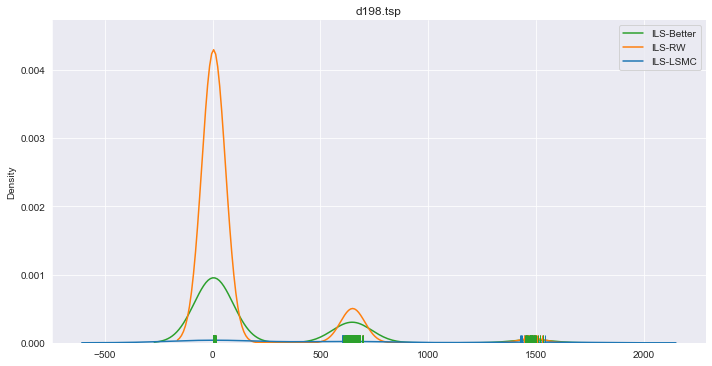

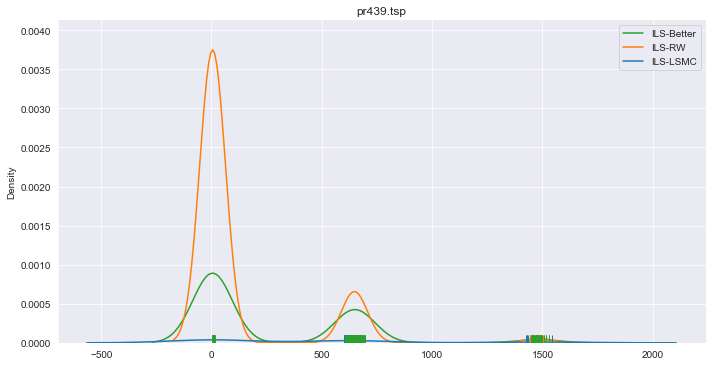

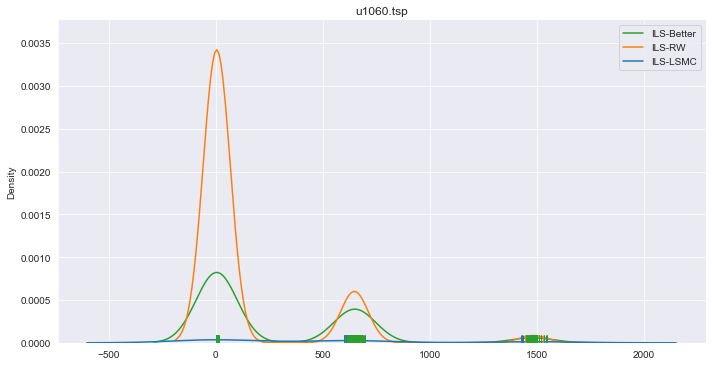

In [115]:
# Alternative
DFs = []
for instance in names_instances:
  dfs = []
  for improve in improvements:
    dfs.append(pd.DataFrame(samples[instance][improve]))
  DFs.append(pd.concat(dfs, ignore_index=True, axis=1))

for i, instance in enumerate(names_instances):
  sns.displot(data=DFs[i], rug=True, kind='kde', legend=False, aspect=2)

  plt.legend(labels=improvements)
  plt.title(instance)
  plt.show()

1541.33
13.67
1495.11


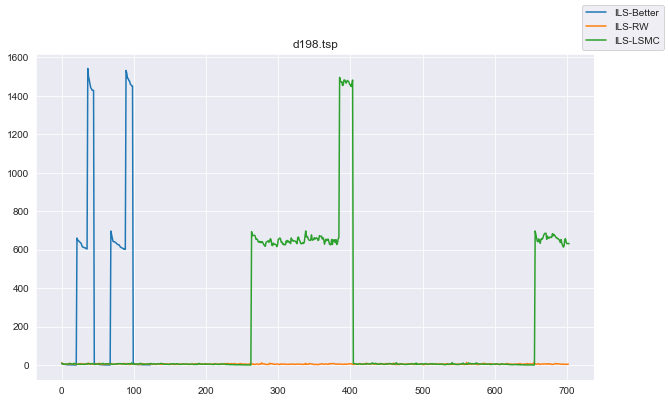

1541.33
13.67
1495.11


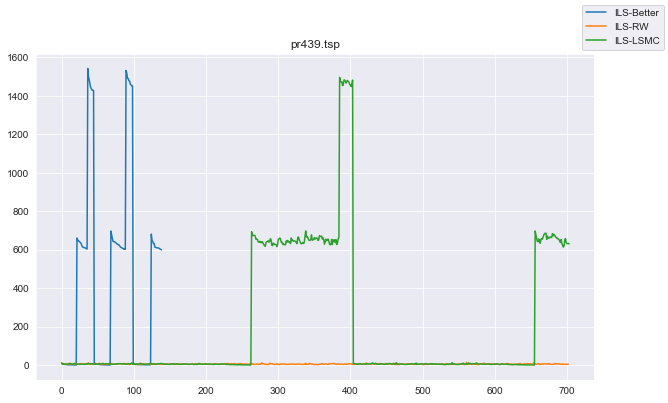

1548.81
13.67
1495.11


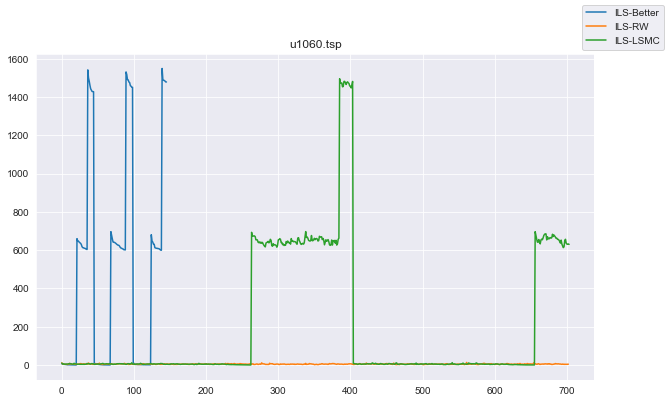

In [116]:
# Alternative
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      data_for_seed_0_idx = results[j * 3][-1]
      print(max(samples[instance][improve][:data_for_seed_0_idx]))
      sns.lineplot(data=samples[instance][improve][:data_for_seed_0_idx])

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()